In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from scipy.stats import norm

# Set plot style
sns.set_style('darkgrid')

from src.stock_path_simulator import StockPathSimulator
from src.binomial_tree import BinomialTreeSimulator

# Finite american options 

Finite american put options don't have an analytic equation for its value. While the continuation equation for American put option is the same as European put option in the continuation region, its value becomes a constant payoff in the exercise region. In practice, this is known as a linear complementary problem (Shreve, 2004, Chapter 8.4).

For finite time put options, the linear complementary condition is

$$
\begin{align*}
v(t, x) &\geq (K-x)^+ &\forall t \in [0,T), x\geq 0 \\
r v(t, x) - v_t(t, x) - r x v_x(t, x)-\frac{1}{2}\sigma^2 x^2 v_xx(t, x) &\geq 0 ~~~~ &\forall t \in [0,T), x\geq 0
\end{align*}
$$

which intuitively, suggests that (1) the value of the option is greater than when it's immediately exercised and (2) the Black-Scholes drift is positive, meaning the option gains value when one continues it. This yields the the time-dependent Black-Scholes variational inequality

$$
\begin{align*}
r v(t,x) -  v_t(t,x)-r x v_{x}(t, x)-\frac{1}{2}\sigma^2 x^2 v_{xx}(t,x) = \begin{cases}
rK, & \text{if }0<x\leq \{(t,x); v(t,x)>(K-x)^+\}(\text{exercise now}),\\
0, & \text{otherwise } (\text{wait}).
\end{cases}
\end{align*}
$$

This equation determines the optimal exercise boundary $x = L(T-t)$ where the option should be exercised. In addition to the smooth-pasting condition that $v_x(t,x)$ is continuous:

$$
v_x(t, x^+) = v_x(t, x^-) = -1 \text{ for } x = L(T-t), 0\leq t < T
$$

and tne boundary conditions

$$
L(0) = K, v(T, x) = (K-x)^+
$$

these forms a set of equations that allow one to set up a finite-difference scheme to compute $v(t,x)$ and $L(T-t)$. In addition, it can also be approached
using binomial/trinomial trees or simulation-based methods like the Longstaff–Schwartz least-squares Monte Carlo (LS) for the optimal stopping rule. This notebook covers the binomial tree and LS algorithm.

# Binomial tree simulation

A binomial tree is a mechanism where the time-evolution of the asset price is simulated as a binary step, where it can either go up or down  $S\rightarrow uS$ or $S\rightarrow dS$ depending on which step, with probability of $p$ and $1-p$ respectively. Even if there is an exponential amount of step combinations, because the value of a stock only depends on how many total up or down steps are taken, but not on the order in which it is taken, the overall size binomial tree only scales polynomially to the number of steps. The binomial tree algorithm for simulating the value of an American option involves determining its value at the leaf nodes (i.e., if the option is exercised upon expiration), before inducting over previous parents, where the value of the node is taken to be the maximum of its immediate exercise value and continuation value. 


Here we implement a Cox-Ross-Rubinstein logic, which picks the probabliity such that this replicates the mean and variance of a geometric Brownian motion. In CRR, this sets $u=e^{\sigma \sqrt{\Delta t}}$, $d=e^{\sigma \sqrt{-\Delta t}}$, $p = \frac{e^{r\Delta t}- d}{u-d}$.

In [2]:
# Black-Scholes formulas for both puts and calls
def black_scholes_option_price(S0, K, T, r, sigma, option_type='put'):
    """Calculate Black-Scholes option price for puts and calls"""
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type.lower() == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    elif option_type.lower() == 'call':
        option_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        raise ValueError("option_type must be 'put' or 'call'")
    
    return option_price

In [3]:
S0 = 140       # Initial stock price
K = 140        # Strike price
sigma = 0.3    # Volatility
r = 0.035      # Risk-free rate
T = 10         # Time horizon (years)
mu = 0         # Drift (risk-neutral)
n_steps = 1000  # Number of steps in binomial tree

print("=== PUT OPTION COMPARISON ===")
# PUT option
put_binomial_tree = BinomialTreeSimulator(S0, K, T, r, sigma, n_steps=n_steps, option_type='put')

european_put_price_binomial = put_binomial_tree.price_european_option()
print(f"European Put Option Price from Binomial Tree: {european_put_price_binomial:.4f}")

european_put_price_black_scholes = black_scholes_option_price(S0, K, T, r, sigma, 'put')
print(f"European Put Option Price from Black-Scholes: {european_put_price_black_scholes:.4f}")
print(f"Put Price Difference: {abs(european_put_price_binomial - european_put_price_black_scholes):.6f}")

print("\n=== CALL OPTION COMPARISON ===")
# CALL option
call_binomial_tree = BinomialTreeSimulator(S0, K, T, r, sigma, n_steps=n_steps, option_type='call')

european_call_price_binomial = call_binomial_tree.price_european_option()
print(f"European Call Option Price from Binomial Tree: {european_call_price_binomial:.4f}")

european_call_price_black_scholes = black_scholes_option_price(S0, K, T, r, sigma, 'call')
print(f"European Call Option Price from Black-Scholes: {european_call_price_black_scholes:.4f}")
print(f"Call Price Difference: {abs(european_call_price_binomial - european_call_price_black_scholes):.6f}")

# Verify Put-Call Parity: C - P = S0 - K*e^(-rT)
put_call_parity_lhs = european_call_price_black_scholes - european_put_price_black_scholes
put_call_parity_rhs = S0 - K * np.exp(-r * T)
print(f"\n=== PUT-CALL PARITY CHECK ===")
print(f"C - P = {put_call_parity_lhs:.4f}")
print(f"S0 - K*e^(-rT) = {put_call_parity_rhs:.4f}")
print(f"Put-Call Parity Difference: {abs(put_call_parity_lhs - put_call_parity_rhs):.6f}")

=== PUT OPTION COMPARISON ===
European Put Option Price from Binomial Tree: 25.5227
European Put Option Price from Black-Scholes: 25.5339
Put Price Difference: 0.011241

=== CALL OPTION COMPARISON ===
European Put Option Price from Binomial Tree: 25.5227
European Put Option Price from Black-Scholes: 25.5339
Put Price Difference: 0.011241

=== CALL OPTION COMPARISON ===
European Call Option Price from Binomial Tree: 66.8664
European Call Option Price from Black-Scholes: 66.8776
Call Price Difference: 0.011241

=== PUT-CALL PARITY CHECK ===
C - P = 41.3437
S0 - K*e^(-rT) = 41.3437
Put-Call Parity Difference: 0.000000
European Call Option Price from Binomial Tree: 66.8664
European Call Option Price from Black-Scholes: 66.8776
Call Price Difference: 0.011241

=== PUT-CALL PARITY CHECK ===
C - P = 41.3437
S0 - K*e^(-rT) = 41.3437
Put-Call Parity Difference: 0.000000


In [4]:
# Compare American vs European option prices for both puts and calls

print("=== AMERICAN PUT OPTION ===")
american_put_price_binomial = put_binomial_tree.price_american_option()
print(f"American Put Option Price from Binomial Tree: {american_put_price_binomial:.4f}")
print(f"European Put Option Price from Binomial Tree: {european_put_price_binomial:.4f}")

# Premium from early exercise for puts
put_early_exercise_premium = american_put_price_binomial - european_put_price_binomial
print(f"Put Early Exercise Premium: {put_early_exercise_premium:.4f}")

print("\n=== AMERICAN CALL OPTION ===")
american_call_price_binomial = call_binomial_tree.price_american_option()
print(f"American Call Option Price from Binomial Tree: {american_call_price_binomial:.4f}")
print(f"European Call Option Price from Binomial Tree: {european_call_price_binomial:.4f}")

# Premium from early exercise for calls
call_early_exercise_premium = american_call_price_binomial - european_call_price_binomial
print(f"Call Early Exercise Premium: {call_early_exercise_premium:.4f} (should be zero)")

=== AMERICAN PUT OPTION ===
American Put Option Price from Binomial Tree: 32.8105
European Put Option Price from Binomial Tree: 25.5227
Put Early Exercise Premium: 7.2877

=== AMERICAN CALL OPTION ===
American Put Option Price from Binomial Tree: 32.8105
European Put Option Price from Binomial Tree: 25.5227
Put Early Exercise Premium: 7.2877

=== AMERICAN CALL OPTION ===
American Call Option Price from Binomial Tree: 66.8664
European Call Option Price from Binomial Tree: 66.8664
Call Early Exercise Premium: 0.0000 (should be zero)
American Call Option Price from Binomial Tree: 66.8664
European Call Option Price from Binomial Tree: 66.8664
Call Early Exercise Premium: 0.0000 (should be zero)


Below is a benchmark of the accuracy as a function of simulation steps

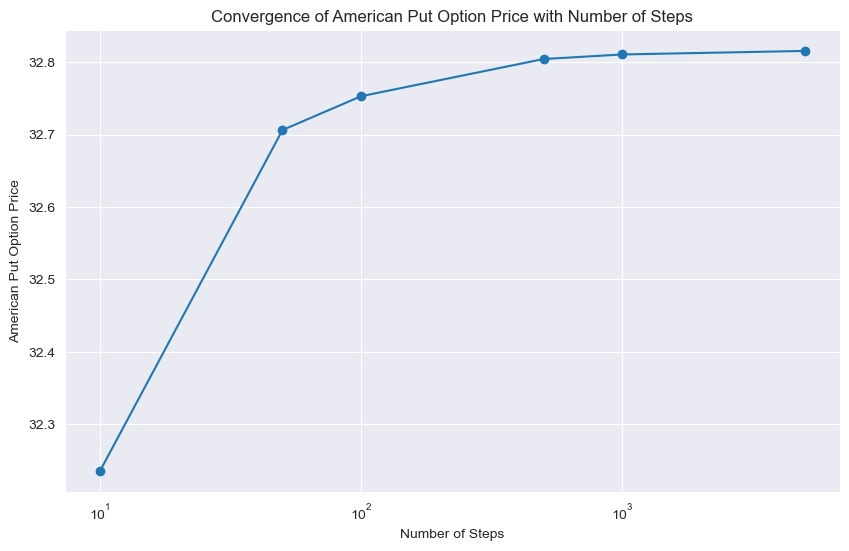

In [5]:
S0 = 140       # Initial stock price
K = 140        # Strike price
sigma = 0.3    # Volatility
r = 0.035      # Risk-free rate
T = 10         # Time horizon (years)
mu = 0         # Drift (risk-neutral)
n_steps = [10, 50, 100, 500, 1000, 5000]  # Number of steps in binomial tree

# Plot the result
steps_list = []
american_put_prices = []
for steps in n_steps:
    put_binomial_tree = BinomialTreeSimulator(S0, K, T, r, sigma, n_steps=steps, option_type='put')
    american_put_price_binomial = put_binomial_tree.price_american_option()
    steps_list.append(steps)
    american_put_prices.append(american_put_price_binomial)
plt.figure(figsize=(10, 6))
plt.plot(steps_list, american_put_prices, marker='o')
plt.xscale('log')
plt.xlabel('Number of Steps')
plt.ylabel('American Put Option Price')
plt.title('Convergence of American Put Option Price with Number of Steps')
plt.grid(True)
plt.show()

The finite American option doesn't have an analytic solution. To determine its accuracy, we use the perpetual American option's theoretical payoff as a proxy.

In [42]:
# Benchmark: Compare finite American options with perpetual American option pricing
# As T → ∞, the finite American option should converge to the perpetual American option
import time

# Parameters for comparison
S0_test = 140
K_test = 140
sigma_test = 0.3
r_test = 0.035

# Calculate theoretical perpetual American put option value
# From notebook 1: optimal boundary L* = (2r/(2r+σ²))K
alpha = (2 * r_test) / (2 * r_test + sigma_test**2)
L_star = K_test * alpha

# Theoretical value function for perpetual American put at S0
if S0_test <= L_star:
    theoretical_perpetual_value = K_test - S0_test
else:
    theoretical_perpetual_value = (K_test - L_star) * (S0_test / L_star) ** (-2 * r_test / sigma_test**2)

print(f"=== PERPETUAL AMERICAN PUT OPTION (THEORETICAL) ===")
print(f"Optimal exercise boundary L* = {L_star:.2f}")
print(f"Theoretical perpetual American put value: {theoretical_perpetual_value:.4f}")
print()

# Test convergence with different time horizons AND number of steps
T_values = [1, 5, 10, 20, 50, 100, 200, 500]
n_steps_values = [100, 250, 500, 1000, 2000]

# Store results in a structured format
benchmark_results = []

print(f"=== CONVERGENCE ANALYSIS: VARYING T AND n_steps ===")
print(f"Testing {len(T_values)} time horizons × {len(n_steps_values)} step sizes = {len(T_values) * len(n_steps_values)} combinations")
print()

for n_steps_test in n_steps_values:
    print(f"\n--- n_steps = {n_steps_test} ---")
    for T_test in T_values:
        # Price finite American put using binomial tree and measure runtime
        start_time = time.time()
        bt = BinomialTreeSimulator(S0_test, K_test, T_test, r_test, sigma_test, 
                                    n_steps=n_steps_test, option_type='put')
        finite_price = bt.price_american_option()
        runtime = time.time() - start_time
        
        error = abs(finite_price - theoretical_perpetual_value)
        error_pct = 100 * error / theoretical_perpetual_value
        
        # Store results
        benchmark_results.append({
            'T': T_test,
            'n_steps': n_steps_test,
            'price': finite_price,
            'error': error,
            'error_pct': error_pct,
            'runtime': runtime
        })
        
        print(f"T={T_test:4.0f}: Price={finite_price:.4f}, Error={error:.4f} ({error_pct:.2f}%), Runtime={runtime:.4f}s")

# Convert to DataFrame for easier analysis and plotting
results_binomial_df = pd.DataFrame(benchmark_results)

print(f"\n{'='*80}")
print(f"Benchmark complete! Total simulations: {len(results_binomial_df)}")
print(f"Total runtime: {results_binomial_df['runtime'].sum():.2f}s")


=== PERPETUAL AMERICAN PUT OPTION (THEORETICAL) ===
Optimal exercise boundary L* = 61.25
Theoretical perpetual American put value: 41.4010

=== CONVERGENCE ANALYSIS: VARYING T AND n_steps ===
Testing 8 time horizons × 5 step sizes = 40 combinations


--- n_steps = 100 ---
T=   1: Price=14.5595, Error=26.8415 (64.83%), Runtime=0.0126s
T=   5: Price=26.9136, Error=14.4874 (34.99%), Runtime=0.0089s
T=  10: Price=32.7528, Error=8.6482 (20.89%), Runtime=0.0081s
T=  20: Price=37.4862, Error=3.9149 (9.46%), Runtime=0.0078s
T=  50: Price=40.6186, Error=0.7824 (1.89%), Runtime=0.0077s
T= 100: Price=40.8588, Error=0.5422 (1.31%), Runtime=0.0084s
T= 200: Price=40.7318, Error=0.6692 (1.62%), Runtime=0.0076s
T= 500: Price=39.3366, Error=2.0645 (4.99%), Runtime=0.0079s

--- n_steps = 250 ---
T=   1: Price=14.5731, Error=26.8280 (64.80%), Runtime=0.0467s
T=   5: Price=26.9370, Error=14.4640 (34.94%), Runtime=0.0478s
T=  10: Price=32.7916, Error=8.6095 (20.80%), Runtime=0.0462s
T=  20: Price=37.5685, 

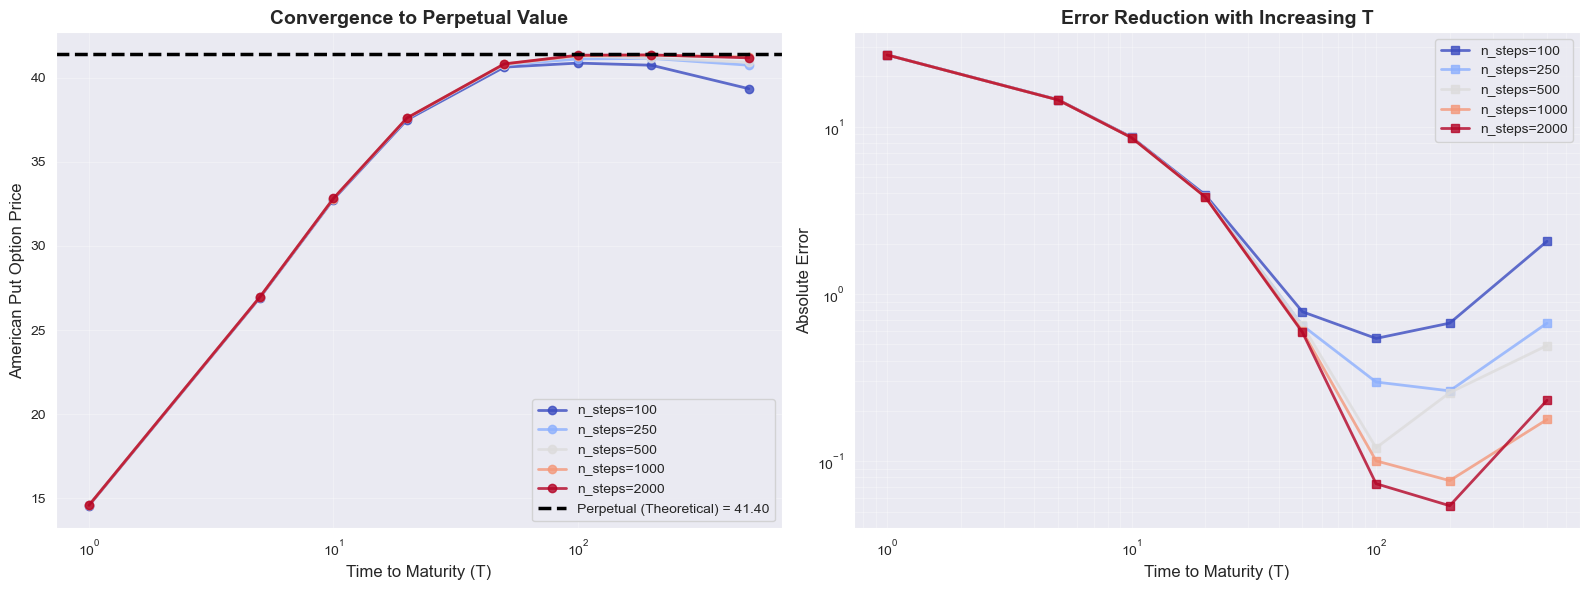


Convergence Analysis:
- Error decreases exponentially with T (roughly linear on log-log plot)
- Diminishing returns: beyond certain T, one needs commensurate n_steps to yield better result


In [43]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Use a colormap for different n_steps values
cmap = plt.cm.coolwarm
colors = [cmap(i / (len(n_steps_values) - 1)) for i in range(len(n_steps_values))]

# Plot 1: Price convergence
ax1 = axes[0]
for idx, n_steps_val in enumerate(n_steps_values):
    subset = results_binomial_df[results_binomial_df['n_steps'] == n_steps_val]
    ax1.plot(subset['T'], subset['price'], marker='o', label=f'n_steps={n_steps_val}',
             color=colors[idx], linewidth=2, markersize=6, alpha=0.8)

ax1.axhline(y=theoretical_perpetual_value, color='black', linestyle='--', 
            label=f'Perpetual (Theoretical) = {theoretical_perpetual_value:.2f}', linewidth=2.5)
ax1.set_xlabel('Time to Maturity (T)', fontsize=12)
ax1.set_ylabel('American Put Option Price', fontsize=12)
ax1.set_title('Convergence to Perpetual Value', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')

# Plot 2: Error convergence (log-log scale)
ax2 = axes[1]
for idx, n_steps_val in enumerate(n_steps_values):
    subset = results_binomial_df[results_binomial_df['n_steps'] == n_steps_val]
    ax2.plot(subset['T'], subset['error'], marker='s', label=f'n_steps={n_steps_val}',
             color=colors[idx], linewidth=2, markersize=6, alpha=0.8)

ax2.set_xlabel('Time to Maturity (T)', fontsize=12)
ax2.set_ylabel('Absolute Error', fontsize=12)
ax2.set_title('Error Reduction with Increasing T', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3, which='both')
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

print("\nConvergence Analysis:")
print("- Error decreases exponentially with T (roughly linear on log-log plot)")
print("- Diminishing returns: beyond certain T, one needs commensurate n_steps to yield better result")


/var/folders/z4/h6nt6cb92jl9jsxg6g7h076m0000gp/T/ipykernel_14877/2458857999.py:29: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/wttai/miniconda3/envs/yfinance/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


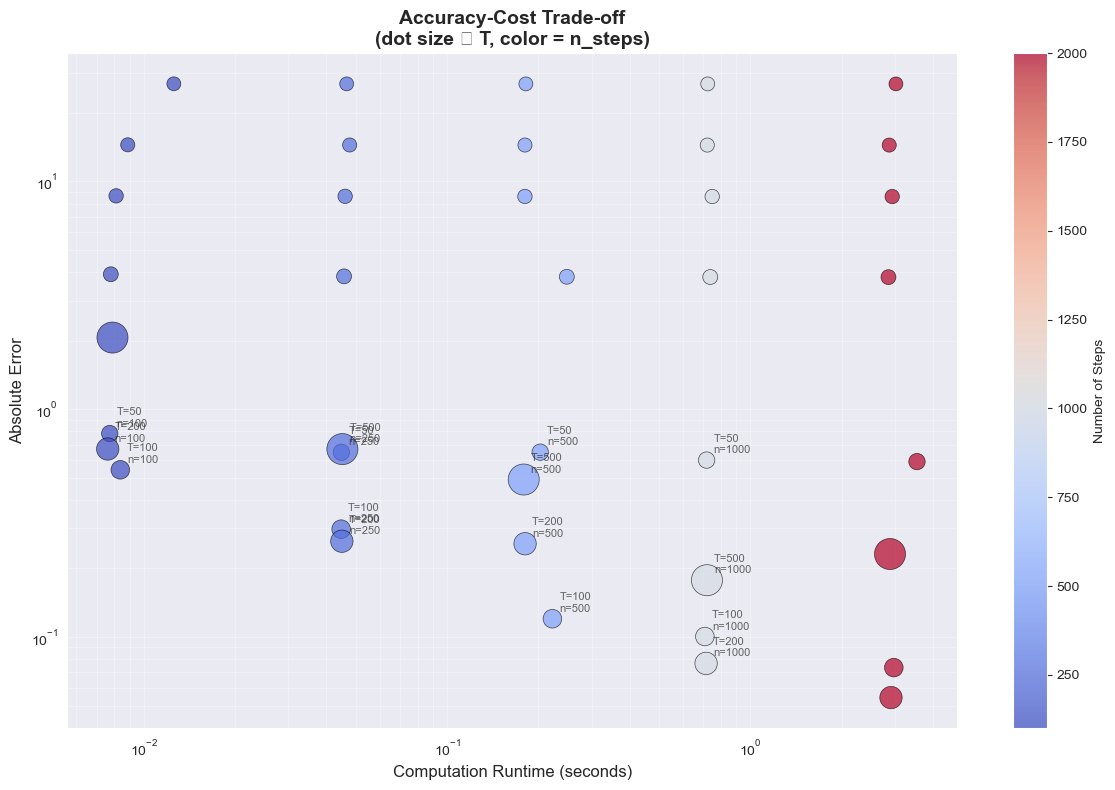

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot: error vs runtime, colored by n_steps, sized by T
T_min, T_max = results_binomial_df['T'].min(), results_binomial_df['T'].max()
sizes = 100 + 400 * (results_binomial_df['T'] - T_min) / (T_max - T_min)

scatter = ax.scatter(results_binomial_df['runtime'], results_binomial_df['error'], 
                     c=results_binomial_df['n_steps'], s=sizes, alpha=0.7, 
                     cmap='coolwarm', edgecolors='black', linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Number of Steps')

# Annotate a few key points
for idx, row in results_binomial_df.iterrows():
    if row['error'] < 1 and row['runtime'] < 2:  # Annotate interesting points
        ax.annotate(f"T={int(row['T'])}\nn={int(row['n_steps'])}", 
                   xy=(row['runtime'], row['error']),
                   xytext=(5, 5), textcoords='offset points', 
                   fontsize=8, alpha=0.7)

ax.set_xlabel('Computation Runtime (seconds)', fontsize=12)
ax.set_ylabel('Absolute Error', fontsize=12)
ax.set_title('fAccuracy-Cost Trade-off\n(dot size $∝$ T, color = n_steps)', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

The accuracy of this algorithm is monotonic: increasing the time horizon and number directly yields better result at a time tradeoff. Also, the computation runtime is a function almost solely determined by the number of steps, as one expects.

# Longstaff-Schwarz algorithm

The Longstaff-Schwartz algorithm is a Monte Carlo method for pricing American options. It uses least squares regression to estimate the continuation value of the option at each time step.

## Algorithm Steps:

1. **Simulate Stock Price Paths**: Generate many paths of the underlying asset using geometric Brownian motion
2. **Initialize Cash Flows**: Set terminal payoffs at expiration
3. **Backward Induction**: Work backwards from expiration:
   - For each time step, identify in-the-money paths
   - Use regression to estimate continuation value based on current stock price
   - Compare immediate exercise value vs. continuation value
   - Exercise if immediate value > continuation value
4. **Discount to Present**: Calculate the option value by discounting cash flows

In [45]:
from src.stock_path_simulator import StockPathSimulator

class LongstaffSchwartzSimulator(StockPathSimulator):
    def __init__(self, S0, K, T, r, sigma, n_sims, n_steps, option_type='put'):
        super().__init__(S0=S0, sigma=sigma, T=T, r=r, mu=0, n_sims=n_sims, n_steps=n_steps)  # mu=0 for risk-neutral
        self.K = K
        self.option_type = option_type.lower()
        self.dt = self.T / self.n_steps
        self.discount_factor = np.exp(-self.r * self.dt)

    def calculate_payoff(self, stock_prices):
        """Calculate option payoff"""
        if self.option_type == 'put':
            return np.maximum(self.K - stock_prices, 0)
        elif self.option_type == 'call':
            return np.maximum(stock_prices - self.K, 0)
        else:
            raise ValueError("option_type must be 'put' or 'call'")
    
    def basis_functions(self, stock_prices):
        """
        Define basis functions for regression
        Using weighted Laguerre polynomials as in the original Longstaff-Schwartz paper
        """
        x = stock_prices / self.K  # Normalize by strike price
        
        # Weighted Laguerre polynomials with exponential factor e^(-x/2)
        # L0(x) = e^(-x/2), L1(x) = e^(-x/2)(1-x), L2(x) = e^(-x/2)(1-2x+x²/2)
        exp_factor = np.exp(-x / 2)
        L0 = exp_factor
        L1 = exp_factor * (1 - x)
        L2 = exp_factor * (1 - 2*x + 0.5*x**2)
        
        return np.column_stack([L0, L1, L2])
    
    def price_american_option(self, return_std_error=False):
        """
        Price American option using Longstaff-Schwartz algorithm
        
        Parameters:
        -----------
        return_std_error : bool
            If True, returns (price, standard_error) tuple
            If False, returns only price
        """
        cash_flows = np.zeros((self.n_sims, self.n_steps + 1))

        # Step 1: Payoff at maturity
        cash_flows[:, -1] = self.calculate_payoff(self.stock_paths[:, -1])

        # Backward induction
        for t in range(self.n_steps - 1, 0, -1):
            # Consider early exercise at time t

            # Step 2: Calculate immediate exercise value
            exercise_value = self.calculate_payoff(self.stock_paths[:, t])
            # Find paths where immediate exercise is profitable (in-the-money)
            in_the_money = exercise_value > 0
            if np.sum(in_the_money) == 0:
                continue  # No paths are in-the-money, skip to next time step

            # Step 3: For in the money paths, estimate continuation value using regression
            # We want regression E(Y|X), where Y is the discounted cash flows from t+1 onward given stock price X at time t
            # This is the same notation in the Longstaff-Schwartz paper

            if len(np.where(in_the_money)[0]) < 3:
                # Not enough points to perform regression
                continue
            else:
                # Prepare regression data
                # For Y, we look at the maximum cash flow from t+1 onward for each path
                Y = np.zeros(np.sum(in_the_money))
                for i, path_idx in enumerate(np.where(in_the_money)[0]):
                    # Find the next non-zero cash flow for this path
                    future_cf_times = np.where(cash_flows[path_idx, t+1:] > 0)[0]
                    if len(future_cf_times) >= 2:
                        raise ValueError("Multiple future cash flows found, which should not happen in Longstaff-Schwartz.")
                    if len(future_cf_times) > 0:
                        next_cf_time = future_cf_times[0] + t + 1
                        discount_periods = next_cf_time - t
                        Y[i] = (cash_flows[path_idx, next_cf_time] * 
                                        (self.discount_factor ** discount_periods))

                X = self.basis_functions(self.stock_paths[in_the_money, t])

                # Regression to estimate continuation value
                try:
                    beta = np.linalg.lstsq(X, Y, rcond=None)[0]
                    continuation_values = X @ beta
                except np.linalg.LinAlgError:
                    raise ValueError("Regression failed at time step", t)
            
            # Step 4: Decide whether to exercise or continue
            itm_exercise_values = exercise_value[in_the_money]
            exercise_now = itm_exercise_values > continuation_values
            itm_indices = np.where(in_the_money)[0]
            exercise_indices = itm_indices[exercise_now]

            # Set cash flows for paths where we exercise now
            cash_flows[:, t] = 0  # Reset current time cash flows
            cash_flows[exercise_indices, t] = exercise_value[exercise_indices]

            # Clear future cash flows for paths where we exercise now
            # The logic is that if we want to exercise now, we cannot exercise later
            for idx in exercise_indices:
                cash_flows[idx, t+1:] = 0


        # Calculate option value at t=0
        # Discount all cash flows back to present value
        option_values = np.zeros(self.n_sims)
        for path in range(self.n_sims):
            cf_times = np.where(cash_flows[path, :] > 0)[0]
            if len(cf_times) > 0:
                cf_time = cf_times[0]  # First (and should be only) cash flow time
                option_values[path] = (cash_flows[path, cf_time] * 
                                     (self.discount_factor ** cf_time))
        
        if return_std_error:
            mean_price = np.mean(option_values)
            std_error = np.std(option_values, ddof=1) / np.sqrt(self.n_sims)
            return mean_price, std_error
        else:
            return np.mean(option_values)


    def price_european_option_mc(self, return_std_error=False):
        """
        Price European option using Monte Carlo for comparison
        
        Parameters:
        -----------
        return_std_error : bool
            If True, returns (price, standard_error) tuple
            If False, returns only price
        """
        terminal_payoffs = self.calculate_payoff(self.stock_paths[:, -1])
        discounted_payoffs = terminal_payoffs * (self.discount_factor ** self.n_steps)
        
        if return_std_error:
            mean_price = np.mean(discounted_payoffs)
            std_error = np.std(discounted_payoffs, ddof=1) / np.sqrt(self.n_sims)
            return mean_price, std_error
        else:
            return np.mean(discounted_payoffs)

In [46]:
# Test the Longstaff-Schwartz algorithm
n_paths = 5000 # Number of Monte Carlo paths
n_mc_steps = 1000   # Number of time steps for Monte Carlo

print("=== LONGSTAFF-SCHWARTZ ALGORITHM RESULTS ===")

# PUT option using Longstaff-Schwartz
ls_put = LongstaffSchwartzSimulator(S0, K, T, r, sigma, n_paths, n_mc_steps, 'put')
american_put_ls, error_american_put_ls = ls_put.price_american_option(return_std_error= True)
european_put_ls, error_european_put_ls = ls_put.price_european_option_mc(return_std_error= True)

print(f"American Put Price (Longstaff-Schwartz): {american_put_ls:.4f} ± {error_american_put_ls:.4f}")
print(f"European Put Price (Longstaff-Schwartz MC): {european_put_ls:.4f} ± {error_european_put_ls:.4f}")
european_put_price_black_scholes = black_scholes_option_price(S0, K, T, r, sigma, 'put')
print(f"European Put Option Price from Black-Scholes: {european_put_price_black_scholes:.4f}")
print(f"Early Exercise Premium (LS): {american_put_ls - european_put_ls:.4f}")

print("\n=== COMPARISON WITH BINOMIAL TREE ===")
print(f"American Put - Binomial Tree: {american_put_price_binomial:.4f}")
print(f"American Put - Longstaff-Schwartz: {american_put_ls:.4f} ± {error_american_put_ls:.4f}")
print(f"Put Price Difference: {abs(american_put_price_binomial - american_put_ls):.4f}")


print(f"\n=== COMPARISON WITH BLACK-SCHOLES (EUROPEAN) ===")
print(f"The LS algorithm also provides a Monte-Carlo estimate for European-style options.")
print(f"European Put - Black-Scholes: {european_put_price_black_scholes:.4f}")
print(f"European Put - Longstaff-Schwartz MC: {european_put_ls:.4f} ± {error_european_put_ls:.4f}")
print(f"Put Price Difference: {abs(european_put_price_black_scholes - european_put_ls):.4f}")


=== LONGSTAFF-SCHWARTZ ALGORITHM RESULTS ===
American Put Price (Longstaff-Schwartz): 32.3959 ± 0.3881
European Put Price (Longstaff-Schwartz MC): 25.4970 ± 0.4232
European Put Option Price from Black-Scholes: 25.5339
Early Exercise Premium (LS): 6.8990

=== COMPARISON WITH BINOMIAL TREE ===
American Put - Binomial Tree: 32.8153
American Put - Longstaff-Schwartz: 32.3959 ± 0.3881
Put Price Difference: 0.4194

=== COMPARISON WITH BLACK-SCHOLES (EUROPEAN) ===
The LS algorithm also provides a Monte-Carlo estimate for European-style options.
European Put - Black-Scholes: 25.5339
European Put - Longstaff-Schwartz MC: 25.4970 ± 0.4232
Put Price Difference: 0.0370


While the put option seems accurate, the call option is consistently lower than the Black-Scholes value, which shows clear problem of the simulation. I suspect this is a problem of the algorithm's approximation—for sufficiently long runs, some path would erroneously perform early exercise due to the regression, suppressing the output.

In [47]:
# CALL option using Longstaff-Schwartz
ls_call = LongstaffSchwartzSimulator(S0, K, T, r, sigma, n_paths, n_mc_steps, 'call')
american_call_ls = ls_call.price_american_option()
european_call_ls = ls_call.price_european_option_mc()

print(f"\nAmerican Call Price (Longstaff-Schwartz): {american_call_ls:.4f}")
print(f"European Call Price (Longstaff-Schwartz MC): {european_call_ls:.4f}")
european_call_price_black_scholes = black_scholes_option_price(S0, K, T, r, sigma, 'call')
print(f"European Call Option Price from Black-Scholes: {european_call_price_black_scholes:.4f}")
print(f"Early Exercise Premium (LS): {american_call_ls - european_call_ls:.4f}")


print(f"\nAmerican Call - Binomial Tree: {american_call_price_binomial:.4f}")
print(f"American Call - Longstaff-Schwartz: {american_call_ls:.4f}")
print(f"Call Price Difference: {abs(american_call_price_binomial - american_call_ls):.4f}")


print(f"\nEuropean Call - Black-Scholes: {european_call_price_black_scholes:.4f}")
print(f"European Call - Longstaff-Schwartz MC: {european_call_ls:.4f}")
print(f"Call Price Difference: {abs(european_call_price_black_scholes - european_call_ls):.4f}")


American Call Price (Longstaff-Schwartz): 45.9017
European Call Price (Longstaff-Schwartz MC): 64.8132
European Call Option Price from Black-Scholes: 66.8776
Early Exercise Premium (LS): -18.9115

American Call - Binomial Tree: 66.8664
American Call - Longstaff-Schwartz: 45.9017
Call Price Difference: 20.9646

European Call - Black-Scholes: 66.8776
European Call - Longstaff-Schwartz MC: 64.8132
Call Price Difference: 2.0644


## Monte Carlo Sampling Error of Longstaff-Schwartz algorithm

One feature of the Longstaff-Schwartz algorithm over the binomial tree method is that it can provide **Monte Carlo standard errors**. This allows us to construct confidence intervals for the option price and assess the reliability of our estimate.

The standard error of the mean is calculated as:
$$\text{SE} = \frac{\sigma}{\sqrt{n}}$$

where $\sigma$ is the sample standard deviation of option values across all paths, and $n$ is the number of simulation paths.

Below, we perform the same benchmark of the American put option using Longstaff-Schwartz algorithm in the perpetual option limit.

In [48]:
# Benchmark: Compare finite American options with perpetual American option pricing
# As T → ∞, the finite American option should converge to the perpetual American option
import time

# Parameters for comparison
S0_test = 140
K_test = 140
sigma_test = 0.3
r_test = 0.035

# Calculate theoretical perpetual American put option value
# From notebook 1: optimal boundary L* = (2r/(2r+σ²))K
alpha = (2 * r_test) / (2 * r_test + sigma_test**2)
L_star = K_test * alpha

# Theoretical value function for perpetual American put at S0
if S0_test <= L_star:
    theoretical_perpetual_value = K_test - S0_test
else:
    theoretical_perpetual_value = (K_test - L_star) * (S0_test / L_star) ** (-2 * r_test / sigma_test**2)

print(f"=== PERPETUAL AMERICAN PUT OPTION (THEORETICAL) ===")
print(f"Optimal exercise boundary L* = {L_star:.2f}")
print(f"Theoretical perpetual American put value: {theoretical_perpetual_value:.4f}")
print()

# Test convergence with different time horizons AND number of steps
T_values = [1, 5, 10, 20, 50, 100, 200, 500]
n_steps_values = [100, 250, 500, 1000, 2000]

# Store results in a structured format
benchmark_results = []

print(f"=== CONVERGENCE ANALYSIS: VARYING T AND n_steps ===")
print(f"Testing {len(T_values)} time horizons × {len(n_steps_values)} step sizes = {len(T_values) * len(n_steps_values)} combinations")
print()

for n_steps_test in n_steps_values:
    print(f"\n--- n_steps = {n_steps_test} ---")
    for T_test in T_values:
        # Price finite American put using binomial tree and measure runtime
        start_time = time.time()
        ls_put = LongstaffSchwartzSimulator(S0_test, K_test, T_test, r_test, sigma_test, n_paths, n_mc_steps, 'put')
        finite_price, std_error = ls_put.price_american_option(return_std_error=True)
        runtime = time.time() - start_time
        
        error = abs(finite_price - theoretical_perpetual_value)
        error_pct = 100 * error / theoretical_perpetual_value
        
        # Store results
        benchmark_results.append({
            'T': T_test,
            'n_steps': n_steps_test,
            'price': finite_price,
            'error': error,
            'error_pct': error_pct,
            'std_error': std_error,
            'runtime': runtime
        })
        
        print(f"T={T_test:4.0f}: Price={finite_price:.4f}, Error={error:.4f} ({error_pct:.2f}%), Runtime={runtime:.4f}s")

# Convert to DataFrame for easier analysis and plotting
results_ls_df = pd.DataFrame(benchmark_results)

print(f"\n{'='*80}")
print(f"Benchmark complete! Total simulations: {len(results_ls_df)}")
print(f"Total runtime: {results_ls_df['runtime'].sum():.2f}s")


=== PERPETUAL AMERICAN PUT OPTION (THEORETICAL) ===
Optimal exercise boundary L* = 61.25
Theoretical perpetual American put value: 41.4010

=== CONVERGENCE ANALYSIS: VARYING T AND n_steps ===
Testing 8 time horizons × 5 step sizes = 40 combinations


--- n_steps = 100 ---
T=   1: Price=14.4447, Error=26.9564 (65.11%), Runtime=3.5959s
T=   5: Price=26.6499, Error=14.7512 (35.63%), Runtime=3.6279s
T=  10: Price=32.0525, Error=9.3485 (22.58%), Runtime=3.5383s
T=  20: Price=37.2399, Error=4.1612 (10.05%), Runtime=3.7870s
T=  50: Price=40.7417, Error=0.6594 (1.59%), Runtime=4.1907s
T= 100: Price=42.3606, Error=0.9596 (2.32%), Runtime=4.3034s
T= 200: Price=42.1119, Error=0.7108 (1.72%), Runtime=4.8251s
T= 500: Price=40.8632, Error=0.5378 (1.30%), Runtime=5.4078s

--- n_steps = 250 ---
T=   1: Price=14.5033, Error=26.8978 (64.97%), Runtime=3.4429s
T=   5: Price=26.8737, Error=14.5274 (35.09%), Runtime=3.6119s
T=  10: Price=32.2018, Error=9.1993 (22.22%), Runtime=3.5966s
T=  20: Price=38.3258,

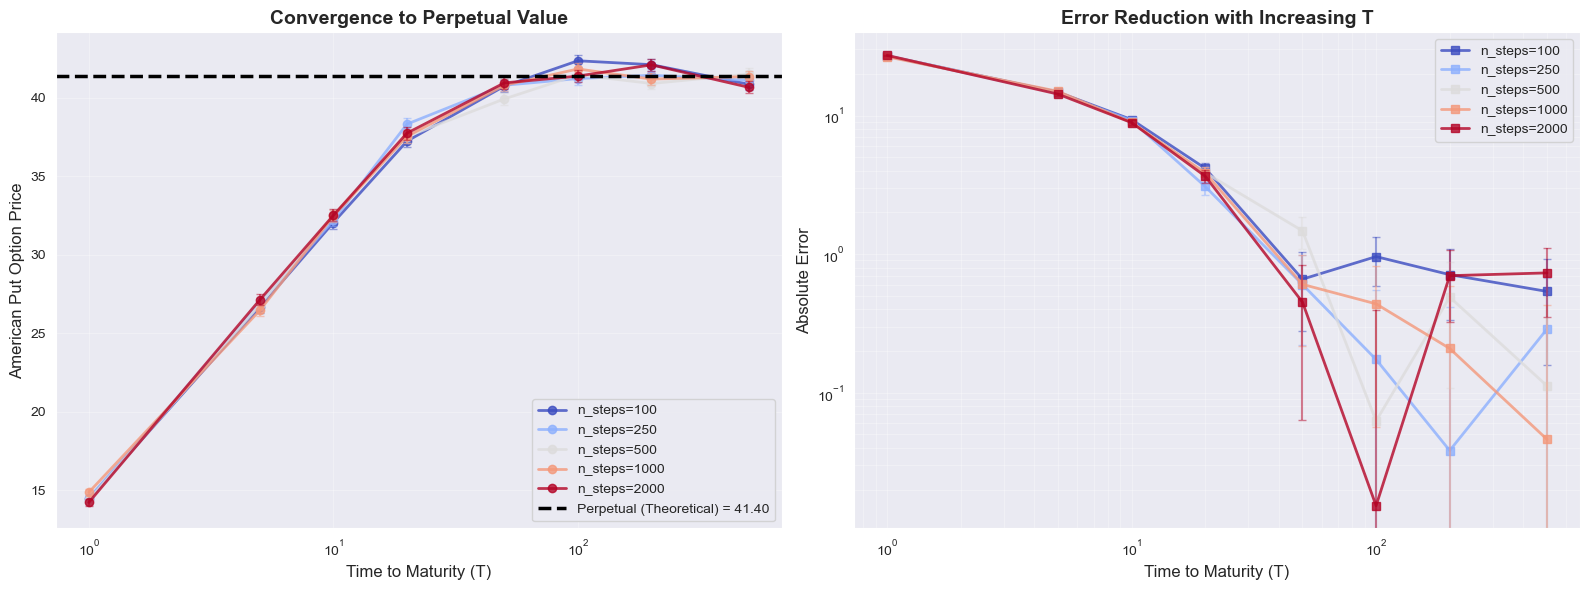


Convergence Analysis:
- Error decreases exponentially with T (roughly linear on log-log plot)
- Diminishing returns: beyond certain T, one needs commensurate n_steps to yield better result


In [49]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Use a colormap for different n_steps values
cmap = plt.cm.coolwarm
colors = [cmap(i / (len(n_steps_values) - 1)) for i in range(len(n_steps_values))]

# Plot 1: Price convergence
ax1 = axes[0]
for idx, n_steps_val in enumerate(n_steps_values):
    subset = results_ls_df[results_ls_df['n_steps'] == n_steps_val]
    ax1.plot(subset['T'], subset['price'], marker='o', label=f'n_steps={n_steps_val}',
             color=colors[idx], linewidth=2, markersize=6, alpha=0.8)
    ax1.errorbar(subset['T'], subset['price'], yerr=subset['std_error'], fmt='none', ecolor=colors[idx], alpha=0.5, capsize=3)

ax1.axhline(y=theoretical_perpetual_value, color='black', linestyle='--', 
            label=f'Perpetual (Theoretical) = {theoretical_perpetual_value:.2f}', linewidth=2.5)
ax1.set_xlabel('Time to Maturity (T)', fontsize=12)
ax1.set_ylabel('American Put Option Price', fontsize=12)
ax1.set_title('Convergence to Perpetual Value', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')

# Plot 2: Error convergence (log-log scale)
ax2 = axes[1]
for idx, n_steps_val in enumerate(n_steps_values):
    subset = results_ls_df[results_ls_df['n_steps'] == n_steps_val]
    ax2.plot(subset['T'], subset['error'], marker='s', label=f'n_steps={n_steps_val}',
             color=colors[idx], linewidth=2, markersize=6, alpha=0.8)
    ax2.errorbar(subset['T'], subset['error'], yerr=subset['std_error'], fmt='none', ecolor=colors[idx], alpha=0.5, capsize=3)

ax2.set_xlabel('Time to Maturity (T)', fontsize=12)
ax2.set_ylabel('Absolute Error', fontsize=12)
ax2.set_title('Error Reduction with Increasing T', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3, which='both')
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

print("\nConvergence Analysis:")
print("- Error decreases exponentially with T (roughly linear on log-log plot)")
print("- Diminishing returns: beyond certain T, one needs commensurate n_steps to yield better result")


The error bar is not shown below to avoid cluttering the plot.

/var/folders/z4/h6nt6cb92jl9jsxg6g7h076m0000gp/T/ipykernel_14877/1736262724.py:29: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/wttai/miniconda3/envs/yfinance/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


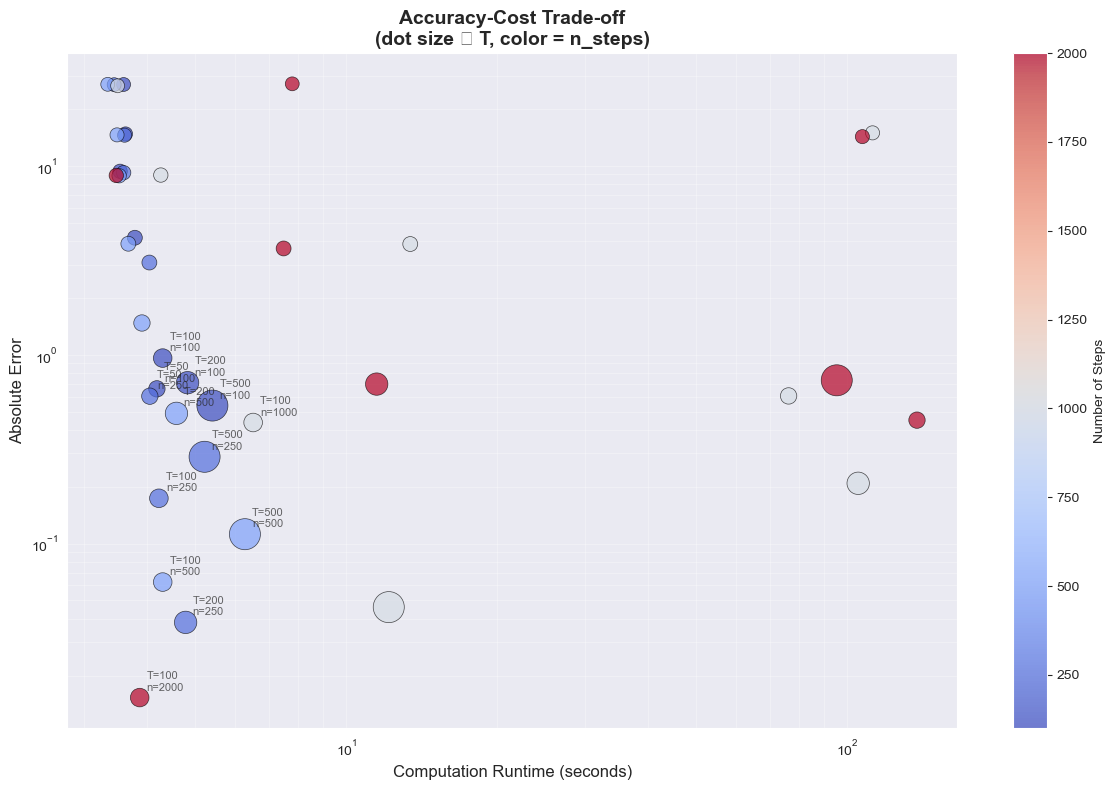

In [53]:
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot: error vs runtime, colored by n_steps, sized by T
T_min, T_max = results_ls_df['T'].min(), results_ls_df['T'].max()
sizes = 100 + 400 * (results_ls_df['T'] - T_min) / (T_max - T_min)

scatter = ax.scatter(results_ls_df['runtime'], results_ls_df['error'], 
                     c=results_ls_df['n_steps'], s=sizes, alpha=0.7, 
                     cmap='coolwarm', edgecolors='black', linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Number of Steps')

# Annotate a few key points
for idx, row in results_ls_df.iterrows():
    if row['error'] < 1 and row['runtime'] < 10:  # Annotate interesting points
        ax.annotate(f"T={int(row['T'])}\nn={int(row['n_steps'])}", 
                   xy=(row['runtime'], row['error']),
                   xytext=(5, 5), textcoords='offset points', 
                   fontsize=8, alpha=0.7)

ax.set_xlabel('Computation Runtime (seconds)', fontsize=12)
ax.set_ylabel('Absolute Error', fontsize=12)
ax.set_title('Accuracy-Cost Trade-off\n(dot size ∝ T, color = n_steps)', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

The accuracy of Longstaff-Schwartz algorithm is comparable to binomial tree. Let's also compare the accuracy/runtime the binomial tree and LS algorithm

## Accuracy/Runtime Comparison: LS Monte Carlo vs Binomial Tree

Comparing the two methods to see which achieves better accuracy for a given computational budget.

In [60]:
# Prepare data for comparison - add method labels
results_ls_comparison = results_ls_df.copy()
results_ls_comparison['method'] = 'LS Monte Carlo'

results_binomial_comparison = results_binomial_df.copy()
results_binomial_comparison['method'] = 'Binomial Tree'

# Combine both datasets
results_combined = pd.concat([results_ls_comparison, results_binomial_comparison], ignore_index=True)

print(f"Combined dataset: {len(results_combined)} total simulations")
print(f"LS Monte Carlo: {len(results_ls_comparison)} simulations")
print(f"Binomial Tree: {len(results_binomial_comparison)} simulations")

Combined dataset: 80 total simulations
LS Monte Carlo: 40 simulations
Binomial Tree: 40 simulations


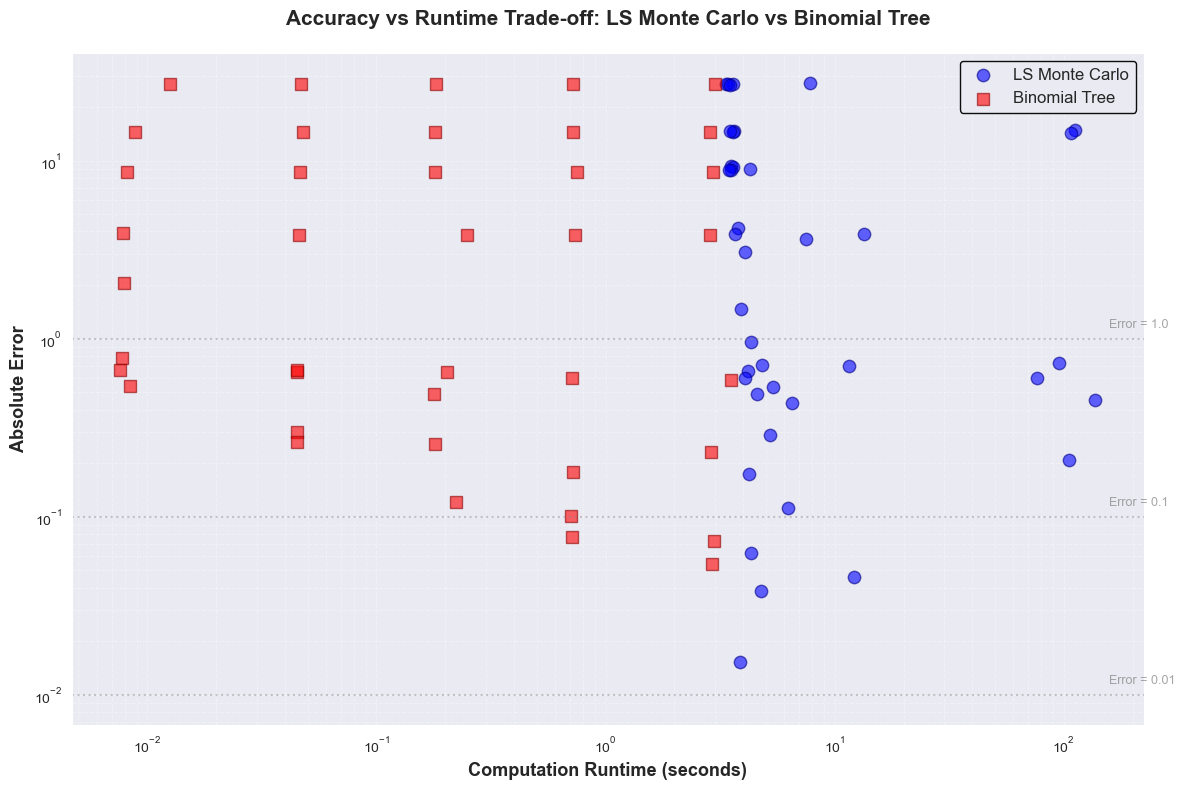


Key Observations:
• Blue circles = LS Monte Carlo, Red squares = Binomial Tree
• Lower-left corner = Better (low error, low runtime)


In [62]:
# Accuracy vs Runtime Comparison
fig, ax = plt.subplots(figsize=(12, 8))

# Plot LS Monte Carlo results
ls_data = results_combined[results_combined['method'] == 'LS Monte Carlo']
scatter_ls = ax.scatter(ls_data['runtime'], ls_data['error'], 
                        s=80, alpha=0.6, color='blue',
                        edgecolors='darkblue', linewidth=1,
                        marker='o', label='LS Monte Carlo')

# Plot Binomial Tree results
bt_data = results_combined[results_combined['method'] == 'Binomial Tree']
scatter_bt = ax.scatter(bt_data['runtime'], bt_data['error'],
                        s=80, alpha=0.6, color='red',
                        edgecolors='darkred', linewidth=1,
                        marker='s', label='Binomial Tree')

# Formatting
ax.set_xlabel('Computation Runtime (seconds)', fontsize=13, fontweight='bold')
ax.set_ylabel('Absolute Error', fontsize=13, fontweight='bold')
ax.set_title('Accuracy vs Runtime Trade-off: LS Monte Carlo vs Binomial Tree', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, which='both', linestyle='--')
ax.legend(loc='upper right', fontsize=12, framealpha=0.95, edgecolor='black')

# Add reference lines for different error thresholds
error_thresholds = [0.01, 0.1, 1.0]
for threshold in error_thresholds:
    ax.axhline(y=threshold, color='gray', linestyle=':', alpha=0.4, linewidth=1.5)
    ax.text(ax.get_xlim()[1] * 0.7, threshold * 1.15, f'Error = {threshold}', 
            fontsize=9, color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("• Blue circles = LS Monte Carlo, Red squares = Binomial Tree")
print("• Lower-left corner = Better (low error, low runtime)")

Here, we see that binomial tree has a consistently lower runtime than the LS algorithm to generate comparable error. Even if a couple points from the LS algorithm show the lowest absolute error, one must bear in mind that there are uncertainties due to the Monte-Carlo sampling error, which reduces their reliability. On the contrary, the binomial tree is deterministic and cheaper per step. Thus, for this simple model, the CRR binomial tree achieves better performance. Longstaff-Schwarz would be more ideal in more complicated models, for example, ones that involve stochastic volatility or path-dependent payoffs. 

# Alternative models of binomial tree

The binomial tree originally proposed by Cox-Ross-Rubinstein has $u=e^{\sigma \sqrt{\Delta t}}$, $d=e^{\sigma \sqrt{-\Delta t}}$, $p = \frac{e^{r\Delta t}- d}{u-d}$. Several other alternatives can be chosen, e.g.:

- Jarrow-Rudd: $p = 1/2$, $u = \exp{\left[(r-\sigma^2/2) \Delta t + \sigma \sqrt{\Delta t}\right]}$, $d = \exp{\left[(r-\sigma^2/2) \Delta t - \sigma \sqrt{\Delta t}\right]}$
- Tian: $p = \frac{e^{r \Delta t} - d}{u-d}$, $u = 0.5 e^{r\Delta t} \nu (\nu + 1 + \sqrt{\nu^2+2\nu-3})$, $d = 0.5 e^{r\Delta t} \nu (\nu + 1 - \sqrt{\nu^2+2\nu-3})$, $\nu = e^{\sigma^2 \Delta t}$ 

# Benchmarking Different Binomial Tree Models

Now let's compare the three binomial tree models (CRR, Jarrow-Rudd, and Tian) to see how they perform in terms of accuracy and runtime.

In [41]:
# Benchmark all three binomial tree models: CRR, Jarrow-Rudd, and Tian
# Extended to test multiple scenarios: different volatilities and strike prices

models = ['CRR', 'JR', 'Tian']
T_values = [1, 5, 10, 20, 50, 100, 200, 500]
n_steps_values = [100, 250, 500, 1000]

# Define test parameters
S0_test = 140  # Fixed spot price
r_test = 0.035

# Test different volatilities and strike prices
sigma_values = [0.1, 0.2, 0.3, 0.4]  # Different volatility levels
K_values = [50, 80, 110, 140, 160]       # Different strike prices (ITM, ATM, OTM for puts)

# Generate all combinations of sigma and K
test_scenarios = []
for sigma in sigma_values:
    for K in K_values:
        test_scenarios.append({
            'S0': S0_test,
            'K': K,
            'sigma': sigma
        })

# Store results for all models and scenarios
all_models_results = []

print(f"=== EXTENDED MULTI-MODEL CONVERGENCE ANALYSIS ===")
print(f"Models: {', '.join(models)}")
print(f"Test Parameters:")
print(f"  S0 = {S0_test}")
print(f"  σ values: {sigma_values}")
print(f"  K values: {K_values}")
print(f"  Scenarios: {len(test_scenarios)} ({len(sigma_values)} × {len(K_values)})")
print(f"\nTesting {len(T_values)} × {len(n_steps_values)} × {len(models)} × {len(test_scenarios)} combinations")
print(f"Total simulations: {len(T_values) * len(n_steps_values) * len(models) * len(test_scenarios)}")
print()

for scenario in test_scenarios:
    S0_scenario = scenario['S0']
    K_scenario = scenario['K']
    sigma_scenario = scenario['sigma']
    
    # Calculate theoretical perpetual American put option value for this scenario
    alpha = (2 * r_test) / (2 * r_test + sigma_scenario**2)
    L_star = K_scenario * alpha
    
    if S0_scenario <= L_star:
        theoretical_perpetual_value = K_scenario - S0_scenario
    else:
        theoretical_perpetual_value = (K_scenario - L_star) * (S0_scenario / L_star) ** (-2 * r_test / sigma_scenario**2)
    
    print(f"\n{'='*80}")
    print(f"SCENARIO: S0={S0_scenario}, K={K_scenario}, σ={sigma_scenario}")
    print(f"Moneyness: {S0_scenario/K_scenario:.3f}, Perpetual Value={theoretical_perpetual_value:.4f}")
    print(f"{'='*80}")
    
    for model in models:
        print(f"\n  Model: {model}")
        
        for n_steps_test in n_steps_values:
            print(f"    n_steps = {n_steps_test}:", end=" ")
            for T_test in T_values:
                # Price finite American put using binomial tree and measure runtime
                start_time = time.time()
                bt = BinomialTreeSimulator(S0_scenario, K_scenario, T_test, r_test, sigma_scenario, 
                                            n_steps=n_steps_test, option_type='put', model=model)
                finite_price = bt.price_american_option()
                runtime = time.time() - start_time
                
                error = abs(finite_price - theoretical_perpetual_value)
                error_pct = 100 * error / theoretical_perpetual_value
                
                # Store results
                all_models_results.append({
                    'S0': S0_scenario,
                    'K': K_scenario,
                    'sigma': sigma_scenario,
                    'moneyness': S0_scenario / K_scenario,
                    'model': model,
                    'T': T_test,
                    'n_steps': n_steps_test,
                    'price': finite_price,
                    'theoretical_value': theoretical_perpetual_value,
                    'error': error,
                    'error_pct': error_pct,
                    'runtime': runtime
                })
                
                print(f"T={T_test}", end=" ")
            print()  # New line after all T values

# Convert to DataFrame for easier analysis and plotting
results_all_models_df = pd.DataFrame(all_models_results)

print(f"\n{'='*80}")
print(f"Benchmark complete! Total simulations: {len(results_all_models_df)}")
print(f"Total runtime: {results_all_models_df['runtime'].sum():.2f}s")
print()

# Summary statistics by model
print("\n=== SUMMARY BY MODEL (ALL SCENARIOS) ===")
for model in models:
    model_data = results_all_models_df[results_all_models_df['model'] == model]
    print(f"\n{model}:")
    print(f"  Mean Error: {model_data['error'].mean():.4f}")
    print(f"  Std Error:  {model_data['error'].std():.4f}")
    print(f"  Min Error:  {model_data['error'].min():.4f}")
    print(f"  Max Error:  {model_data['error'].max():.4f}")
    print(f"  Mean Runtime: {model_data['runtime'].mean():.4f}s")
    print(f"  Total Runtime: {model_data['runtime'].sum():.2f}s")

# Summary statistics by parameter combinations
print("\n=== SUMMARY BY PARAMETER COMBINATION (ALL MODELS) ===")
for sigma in sigma_values:
    for K in K_values:
        scenario_data = results_all_models_df[
            (results_all_models_df['sigma'] == sigma) & 
            (results_all_models_df['K'] == K)
        ]
        if len(scenario_data) > 0:
            print(f"\nσ={sigma}, K={K} (Moneyness={S0_test/K:.3f}):")
            print(f"  Mean Error: {scenario_data['error'].mean():.4f}")
            print(f"  Mean Error %: {scenario_data['error_pct'].mean():.2f}%")
            print(f"  Mean Runtime: {scenario_data['runtime'].mean():.4f}s")

# Save the results to an HDF5 file
results_all_models_df.to_hdf('american_option_benchmark_all_models.h5', 
                              key='benchmark', 
                              mode='w', 
                              complevel=9)
print(f"\nResults saved to 'american_option_benchmark_all_models.h5'")

=== EXTENDED MULTI-MODEL CONVERGENCE ANALYSIS ===
Models: CRR, JR, Tian
Test Parameters:
  S0 = 140
  σ values: [0.1, 0.2, 0.3, 0.4]
  K values: [50, 80, 110, 140, 160]
  Scenarios: 20 (4 × 5)

Testing 8 × 4 × 3 × 20 combinations
Total simulations: 1920


SCENARIO: S0=140, K=50, σ=0.1
Moneyness: 2.800, Perpetual Value=0.0018

  Model: CRR
    n_steps = 100: T=1 T=5 T=10 T=20 T=50 T=100 T=200 T=500 
    n_steps = 250: T=1 T=5 T=10 T=20 T=50 T=100 T=200 T=500 
    n_steps = 500: T=100 T=200 T=500 
    n_steps = 500: T=1 T=5 T=1 T=5 T=10 T=20 T=10 T=20 T=50 T=100 T=50 T=100 T=200 T=500 
    n_steps = 1000: T=200 T=500 
    n_steps = 1000: T=1 T=1 T=5 T=5 T=10 T=10 T=20 T=20 T=50 T=50 T=100 T=100 T=200 T=200 T=500 

  Model: JR
    n_steps = 100: T=1 T=5 T=10 T=20 T=50 T=100 T=200 T=500 
    n_steps = 250: T=1 T=5 T=10 T=20 T=50 T=500 

  Model: JR
    n_steps = 100: T=1 T=5 T=10 T=20 T=50 T=100 T=200 T=500 
    n_steps = 250: T=1 T=5 T=10 T=20 T=50 T=100 T=200 T=500 
    n_steps = 500: T=

In [ ]:
# Load the saved results (for later use)
results_all_models_df = pd.read_hdf('american_option_benchmark_all_models.h5', key='benchmark')

# Define colors and markers for each model
colors = {
    'CRR': '#1f77b4',
    'JR': '#ff7f0e',
    'Tian': '#2ca02c'
}

markers = {
    'CRR': 'o',
    'JR': 's',
    'Tian': '^'
}

We consider a variety of $K$. In all cases, it's found that the CRR and JR have roughly similar performance, with Tian trailing behind.

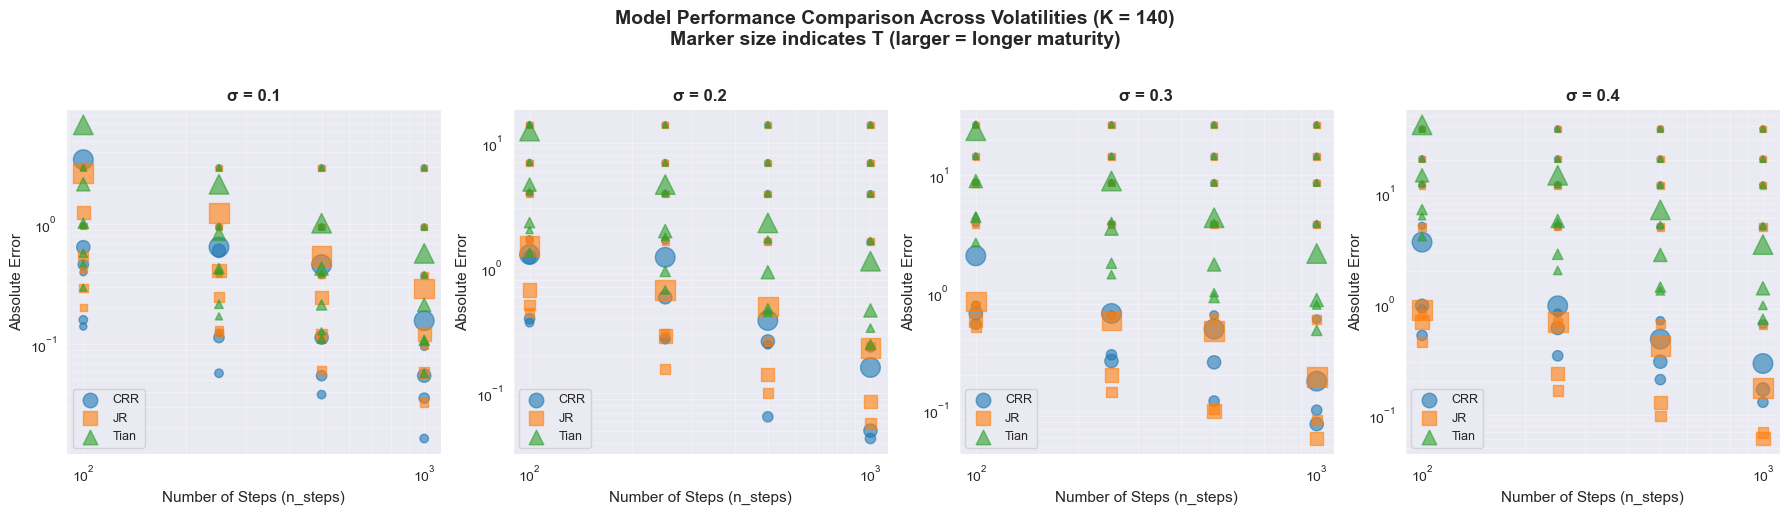

In [45]:
# Compare different volatilities for a given K
K = 140
sigma_values_plot = [0.1, 0.2, 0.3, 0.4]

# Create side-by-side subplots
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Get all T values for consistent marker sizing across subplots
all_T_vals = results_all_models_df['T'].unique()
T_min, T_max = all_T_vals.min(), all_T_vals.max()

for idx, sigma in enumerate(sigma_values_plot):
    ax = axes[idx]
    
    # Filter data for the specific sigma and K values
    filtered_data = results_all_models_df[
        (results_all_models_df['sigma'] == sigma) & 
        (results_all_models_df['K'] == K)
    ]
    
    for model in models:
        model_data = filtered_data[filtered_data['model'] == model]
        
        # Scale marker size based on T (larger T = larger marker)
        marker_sizes = 20 + 180 * (model_data['T'] - T_min) / (T_max - T_min)
        
        ax.scatter(model_data['n_steps'], model_data['error'],
                  alpha=0.6, s=marker_sizes,
                  color=colors.get(model, 'blue'),
                  marker=markers.get(model, 'o'),
                  label=model)
    
    ax.set_xlabel('Number of Steps (n_steps)', fontsize=11)
    ax.set_ylabel('Absolute Error', fontsize=11)
    ax.set_title(f'σ = {sigma}', fontsize=12, fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3, which='both')
    ax.legend(fontsize=9)

fig.suptitle(f'Model Performance Comparison Across Volatilities (K = {K})\nMarker size indicates T (larger = longer maturity)', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

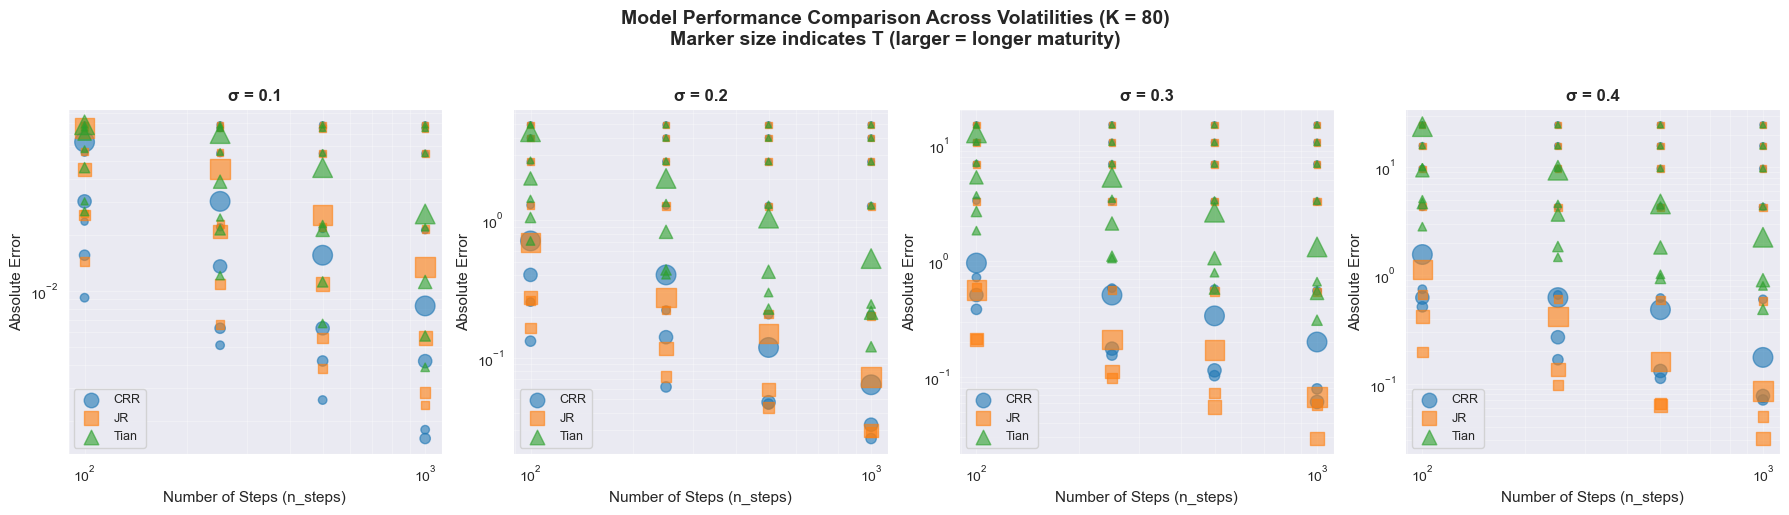

In [48]:
# Compare different volatilities for a given K
K = 80
sigma_values_plot = [0.1, 0.2, 0.3, 0.4]

# Create side-by-side subplots
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Get all T values for consistent marker sizing across subplots
all_T_vals = results_all_models_df['T'].unique()
T_min, T_max = all_T_vals.min(), all_T_vals.max()

for idx, sigma in enumerate(sigma_values_plot):
    ax = axes[idx]
    
    # Filter data for the specific sigma and K values
    filtered_data = results_all_models_df[
        (results_all_models_df['sigma'] == sigma) & 
        (results_all_models_df['K'] == K)
    ]
    
    for model in models:
        model_data = filtered_data[filtered_data['model'] == model]
        
        # Scale marker size based on T (larger T = larger marker)
        marker_sizes = 20 + 180 * (model_data['T'] - T_min) / (T_max - T_min)
        
        ax.scatter(model_data['n_steps'], model_data['error'],
                  alpha=0.6, s=marker_sizes,
                  color=colors.get(model, 'blue'),
                  marker=markers.get(model, 'o'),
                  label=model)
    
    ax.set_xlabel('Number of Steps (n_steps)', fontsize=11)
    ax.set_ylabel('Absolute Error', fontsize=11)
    ax.set_title(f'σ = {sigma}', fontsize=12, fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3, which='both')
    ax.legend(fontsize=9)

fig.suptitle(f'Model Performance Comparison Across Volatilities (K = {K})\nMarker size indicates T (larger = longer maturity)', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

## When Does Tian Excel?

The Tian model's theoretical advantage comes from matching the third moment (skewness) of the log-normal distribution. However, this advantage is most visible in specific regimes:

1. **Short maturities with few steps**: Where higher-order moment matching matters more
2. **Extreme moneyness**: Deep ITM or OTM options where skewness effects are pronounced
3. **Low step counts**: Where the $O(\Delta t^3)$ error term dominates

In the perpetual option limit ($T \rightarrow \infty$) that we're testing, all three models should converge similarly. The plots above show this: differences between models are minimal and comparable to numerical noise. Tian in fact has worse rate of convergence compared to the other regimes. 

Let's examine a regime where Tian's advantages might be more visible: **short-dated options with varying step counts**. To test this for a small $T$ regime, we can no longer rely on the perpetual American option limit. Instead, we use a very long n_steps from CRR as a benchmark.

In [ ]:
# Benchmark models for SHORT maturity using high-precision CRR as reference
# Strategy: Use CRR with very large n_steps as the "true" value, then test all models
# Warning: this cell took a few hours to run because of the n_steps=10000 benchmarks

models = ['CRR', 'JR', 'Tian']
T_values = [0.25, 0.5, 1, 2, 5, 10]  # Short maturities
n_steps_test_values = [50, 100, 250, 500, 1000]  # Steps to test for all models
n_steps_benchmark = 10000  # High-precision benchmark (only for CRR)

# Define test parameters
S0_test = 140  # Fixed spot price
r_test = 0.035

# Test different volatilities and strike prices
sigma_values = [0.1, 0.2, 0.3, 0.4]  # Different volatility levels
K_values = [50, 80, 110, 140, 160]  # Different strike prices (ITM, ATM, OTM for puts)

# Generate all combinations of sigma and K
test_scenarios = []
for sigma in sigma_values:
    for K in K_values:
        test_scenarios.append({
            'S0': S0_test,
            'K': K,
            'sigma': sigma
        })

# Store results for all models and scenarios
all_models_results = []

print(f"=== SHORT MATURITY MODEL COMPARISON ===")
print(f"Using high-precision CRR (n_steps={n_steps_benchmark}) as benchmark")
print(f"Models: {', '.join(models)}")
print(f"Test Parameters:")
print(f"  S0 = {S0_test}")
print(f"  T values: {T_values}")
print(f"  σ values: {sigma_values}")
print(f"  K values: {K_values}")
print(f"  Scenarios: {len(test_scenarios)} ({len(sigma_values)} × {len(K_values)})")
print(f"\nTesting {len(T_values)} × {len(n_steps_test_values)} × {len(models)} × {len(test_scenarios)} combinations")
print(f"Total simulations: {len(T_values) * len(n_steps_test_values) * len(models) * len(test_scenarios)}")
print()

for scenario in test_scenarios:
    S0_scenario = scenario['S0']
    K_scenario = scenario['K']
    sigma_scenario = scenario['sigma']
    
    print(f"\n{'='*80}")
    print(f"SCENARIO: S0={S0_scenario}, K={K_scenario}, σ={sigma_scenario}")
    print(f"Moneyness: {S0_scenario/K_scenario:.3f}")
    print(f"{'='*80}")
    
    # For each T, compute high-precision CRR benchmark
    for T_test in T_values:
        # Compute benchmark value using high-precision CRR
        print(f"\n  Computing benchmark for T={T_test}...")
        bt_benchmark = BinomialTreeSimulator(S0_scenario, K_scenario, T_test, r_test, sigma_scenario, 
                                            n_steps=n_steps_benchmark, option_type='put', model='CRR')
        benchmark_price = bt_benchmark.price_american_option()
        print(f"  Benchmark price (CRR, n={n_steps_benchmark}): {benchmark_price:.6f}")
        
        # Now test all models at different step counts
        for model in models:
            for n_steps_test in n_steps_test_values:
                # Price finite American put using binomial tree and measure runtime
                start_time = time.time()
                bt = BinomialTreeSimulator(S0_scenario, K_scenario, T_test, r_test, sigma_scenario, 
                                            n_steps=n_steps_test, option_type='put', model=model)
                finite_price = bt.price_american_option()
                runtime = time.time() - start_time
                
                error = abs(finite_price - benchmark_price)
                error_pct = 100 * error / benchmark_price if benchmark_price != 0 else 0
                
                # Store results
                all_models_results.append({
                    'S0': S0_scenario,
                    'K': K_scenario,
                    'sigma': sigma_scenario,
                    'moneyness': S0_scenario / K_scenario,
                    'model': model,
                    'T': T_test,
                    'n_steps': n_steps_test,
                    'price': finite_price,
                    'benchmark_price': benchmark_price,
                    'error': error,
                    'error_pct': error_pct,
                    'runtime': runtime
                })
                
                if n_steps_test == n_steps_test_values[-1]:  # Only print for largest n_steps
                    print(f"    {model}: n={n_steps_test}, Price={finite_price:.6f}, Error={error:.6f}")

# Convert to DataFrame for easier analysis and plotting
results_short_maturity_df = pd.DataFrame(all_models_results)

print(f"\n{'='*80}")
print(f"Benchmark complete! Total simulations: {len(results_short_maturity_df)}")
print(f"Total runtime: {results_short_maturity_df['runtime'].sum():.2f}s")
print()

# Summary statistics by model
print("\n=== SUMMARY BY MODEL (ALL SCENARIOS) ===")
for model in models:
    model_data = results_short_maturity_df[results_short_maturity_df['model'] == model]
    print(f"\n{model}:")
    print(f"  Mean Error: {model_data['error'].mean():.6f}")
    print(f"  Median Error: {model_data['error'].median():.6f}")
    print(f"  Std Error:  {model_data['error'].std():.6f}")
    print(f"  Mean Error %: {model_data['error_pct'].mean():.4f}%")
    print(f"  Mean Runtime: {model_data['runtime'].mean():.4f}s")

# Save the results to an HDF5 file
results_short_maturity_df.to_hdf('american_option_benchmark_short_maturity.h5', 
                                  key='benchmark', 
                                  mode='w', 
                                  complevel=9)
print(f"\nResults saved to 'american_option_benchmark_short_maturity.h5'")

=== SHORT MATURITY MODEL COMPARISON ===
Using high-precision CRR (n_steps=10000) as benchmark
Models: CRR, JR, Tian
Test Parameters:
  S0 = 140
  T values: [0.25, 0.5, 1, 2, 5, 10]
  σ values: [0.1, 0.2, 0.3, 0.4]
  K values: [50, 80, 110, 140, 160]
  Scenarios: 20 (4 × 5)

Testing 6 × 5 × 3 × 20 combinations
Total simulations: 1800


SCENARIO: S0=140, K=50, σ=0.1
Moneyness: 2.800

  Computing benchmark for T=0.25...
  Benchmark price (CRR, n=10000): 0.000000
  Benchmark price (CRR, n=10000): 0.000000
    CRR: n=1000, Price=0.000000, Error=0.000000
    CRR: n=1000, Price=0.000000, Error=0.000000
    JR: n=1000, Price=0.000000, Error=0.000000
    JR: n=1000, Price=0.000000, Error=0.000000
    Tian: n=1000, Price=0.000000, Error=0.000000

  Computing benchmark for T=0.5...
    Tian: n=1000, Price=0.000000, Error=0.000000

  Computing benchmark for T=0.5...
  Benchmark price (CRR, n=10000): 0.000000
  Benchmark price (CRR, n=10000): 0.000000
    CRR: n=1000, Price=0.000000, Error=0.000000

In [7]:
results_short_maturity_df = pd.read_hdf('american_option_benchmark_short_maturity.h5', key='benchmark')

# Define colors and markers for each model
colors = {
    'CRR': '#1f77b4',
    'JR': '#ff7f0e',
    'Tian': '#2ca02c'
}

markers = {
    'CRR': 'o',
    'JR': 's',
    'Tian': '^'
}

We first plot the result from the benchmark high-iteration runs. Unsurprisingly, the put option is more valued at higher maturity time $T$, higher volatility $\sigma$, and higher strike price $K$. Further, for the in-the-money option $K=160$, there is a value in immediate exercise.

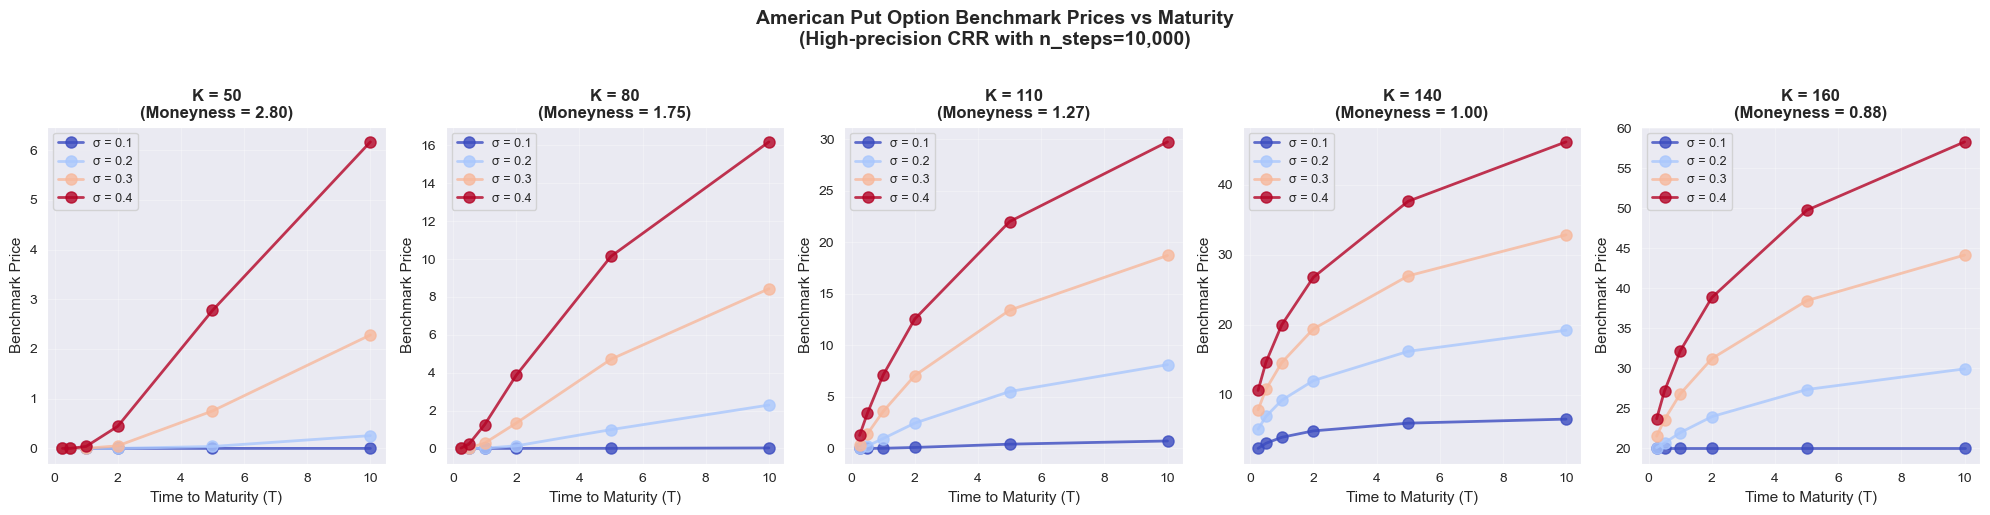

In [21]:
# Plot benchmark prices as a function of T for different scenarios
# Extract unique benchmark prices (one per T, sigma, K combination)
benchmark_prices = results_short_maturity_df[['T', 'sigma', 'K', 'benchmark_price']].drop_duplicates()

# Create subplots for different K values
K_values_plot = sorted(benchmark_prices['K'].unique())
fig, axes = plt.subplots(1, len(K_values_plot), figsize=(20, 5))

# Use colormap for different sigma values
sigma_vals = sorted(benchmark_prices['sigma'].unique())
cmap = plt.cm.coolwarm
colors_sigma = {sigma: cmap(i / (len(sigma_vals) - 1)) for i, sigma in enumerate(sigma_vals)}

# Parameters for perpetual option calculation
S0_test = 140
r_test = 0.035

for idx, K_val in enumerate(K_values_plot):
    ax = axes[idx]
    
    # Filter data for this K value
    K_data = benchmark_prices[benchmark_prices['K'] == K_val]
    
    for sigma_val in sigma_vals:
        sigma_data = K_data[K_data['sigma'] == sigma_val].sort_values('T')
        
        ax.plot(sigma_data['T'], sigma_data['benchmark_price'], 
                marker='o', linewidth=2, markersize=8,
                color=colors_sigma[sigma_val],
                label=f'σ = {sigma_val}',
                alpha=0.8)
        
        # Calculate and plot perpetual American option theoretical value
        alpha = (2 * r_test) / (2 * r_test + sigma_val**2)
        L_star = K_val * alpha
        
        if S0_test <= L_star:
            perpetual_value = K_val - S0_test
        else:
            perpetual_value = (K_val - L_star) * (S0_test / L_star) ** (-2 * r_test / sigma_val**2)
        
        # # Add horizontal line for perpetual option value
        # ax.axhline(y=perpetual_value, color=colors_sigma[sigma_val], 
        #           linestyle='--', linewidth=1.5, alpha=0.5)
    
    ax.set_xlabel('Time to Maturity (T)', fontsize=11)
    ax.set_ylabel('Benchmark Price', fontsize=11)
    ax.set_title(f'K = {K_val}\n(Moneyness = {140/K_val:.2f})', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, loc='best')

fig.suptitle('American Put Option Benchmark Prices vs Maturity\n(High-precision CRR with n_steps=10,000)', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

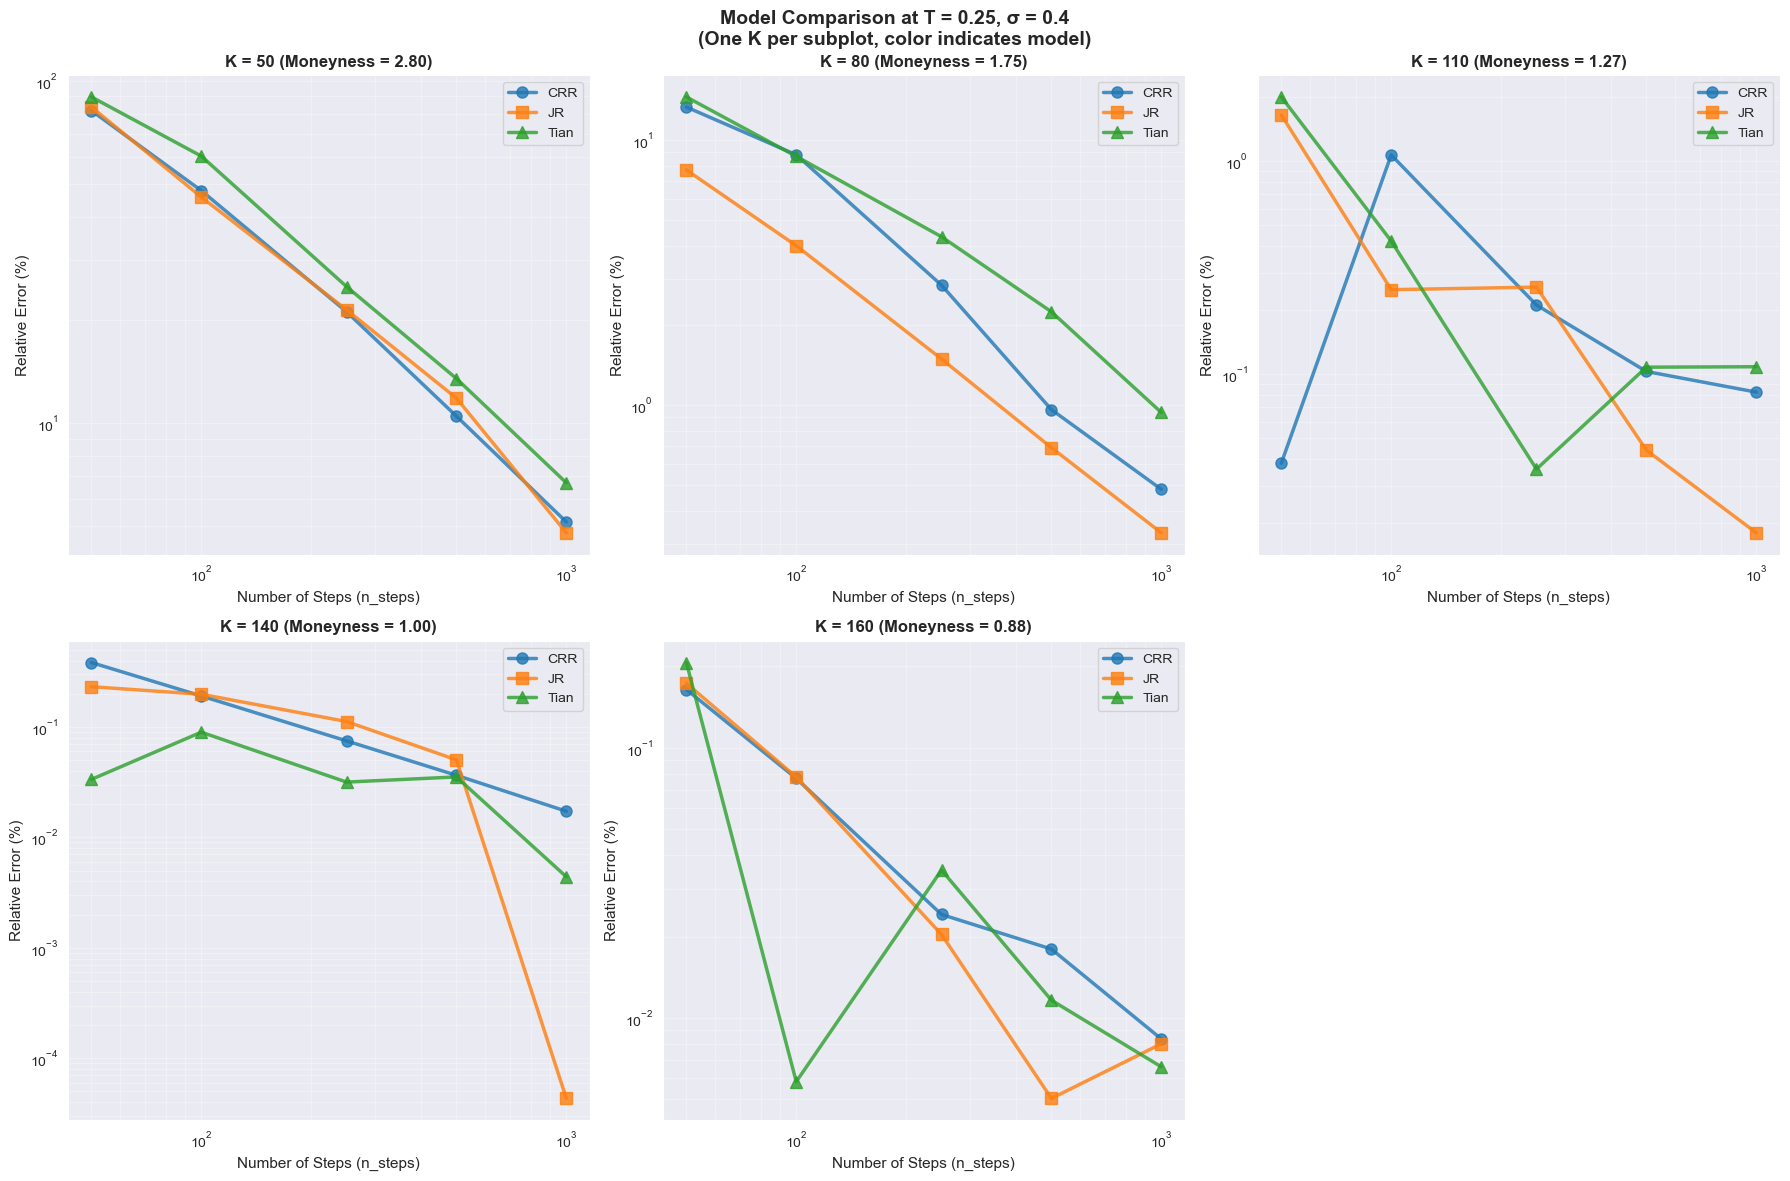

In [60]:
# Model comparison for a single T value using RELATIVE error
# One K value per subplot, with different colors for each model (ansatz)

T_selected = 0.25  # Choose a specific maturity to compare
sigma_selected = 0.4  # Choose a specific volatility

# Filter data for the selected T and sigma
data_filtered = results_short_maturity_df[
    (results_short_maturity_df['T'] == T_selected) & 
    (results_short_maturity_df['sigma'] == sigma_selected)
].copy()

# Get all K values
K_vals = sorted(data_filtered['K'].unique())

# Create subplots - one for each K value
n_cols = 3
n_rows = (len(K_vals) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
axes = axes.flatten() if len(K_vals) > 1 else [axes]

for idx, K_val in enumerate(K_vals):
    ax = axes[idx]
    
    # Filter data for this K value
    K_data = data_filtered[data_filtered['K'] == K_val]
    
    # Plot each model with its own color
    for model in models:
        model_data = K_data[K_data['model'] == model].sort_values('n_steps')
        
        # Plot relative error (%) on y-axis
        ax.plot(model_data['n_steps'], model_data['error_pct'],
               marker=markers.get(model, 'o'),
               color=colors.get(model, 'blue'),
               linewidth=2.5,
               markersize=8,
               label=model,
               alpha=0.8)
    
    ax.set_xlabel('Number of Steps (n_steps)', fontsize=11)
    ax.set_ylabel('Relative Error (%)', fontsize=11)
    ax.set_title(f'K = {K_val} (Moneyness = {140/K_val:.2f})', fontsize=12, fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3, which='both')
    ax.legend(fontsize=10, loc='best')

# Hide any unused subplots
for idx in range(len(K_vals), len(axes)):
    axes[idx].set_visible(False)

fig.suptitle(f'Model Comparison at T = {T_selected}, σ = {sigma_selected}\n(One K per subplot, color indicates model)', 
             fontsize=14, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

## Initial Observations:

The plot above (T=0.25, σ=0.4) shows model comparison at very short maturity. Visual inspection suggests that differences between the three models are relatively small, with no clear systematic winner. To determine whether Tian's theoretical advantage (from matching higher moments) materializes in practice, we perform an analysis below, tally which model achieves the best performance for each parameter combination.

In [62]:
# Quantitative analysis: When does Tian outperform CRR?
# For each (T, sigma, K, n_steps) combination, determine which model has lowest error

small_n_steps = [50, 100, 250, 500, 1000]
short_T = [0.25, 0.5, 1.0, 5.0, 10.0]

analysis_data = results_short_maturity_df[
    (results_short_maturity_df['n_steps'].isin(small_n_steps)) &
    (results_short_maturity_df['T'].isin(short_T))
].copy()

# For each parameter combination, find which model has the lowest error
grouped = analysis_data.groupby(['T', 'sigma', 'K', 'n_steps'])

best_models = []
for name, group in grouped:
    T_val, sigma_val, K_val, n_steps_val = name
    best_model = group.loc[group['error'].idxmin(), 'model']
    best_error = group['error'].min()
    
    best_models.append({
        'T': T_val,
        'sigma': sigma_val,
        'K': K_val,
        'moneyness': 140 / K_val,
        'n_steps': n_steps_val,
        'best_model': best_model,
        'best_error': best_error
    })

best_models_df = pd.DataFrame(best_models)

# Summary statistics
print("=== MODEL PERFORMANCE SUMMARY (SHORT T, LOW N_STEPS) ===")
print(f"\nOverall winner count:")
print(best_models_df['best_model'].value_counts())
print(f"\nPercentage:")
print(best_models_df['best_model'].value_counts(normalize=True) * 100)

# Break down by moneyness
print("\n=== PERFORMANCE BY MONEYNESS ===")
for K_val in sorted(best_models_df['K'].unique()):
    K_subset = best_models_df[best_models_df['K'] == K_val]
    moneyness = 140 / K_val
    print(f"\nK = {K_val} (Moneyness = {moneyness:.2f}):")
    print(K_subset['best_model'].value_counts())
    
# Break down by T
print("\n=== PERFORMANCE BY MATURITY ===")
for T_val in sorted(best_models_df['T'].unique()):
    T_subset = best_models_df[best_models_df['T'] == T_val]
    print(f"\nT = {T_val}:")
    print(T_subset['best_model'].value_counts())

# Break down by n_steps
print("\n=== PERFORMANCE BY N_STEPS ===")
for n_val in sorted(best_models_df['n_steps'].unique()):
    n_subset = best_models_df[best_models_df['n_steps'] == n_val]
    print(f"\nn_steps = {n_val}:")
    print(n_subset['best_model'].value_counts())

# Break down by sigma
print("\n=== PERFORMANCE BY VOLATILITY (σ) ===")
for sigma_val in sorted(best_models_df['sigma'].unique()):
    sigma_subset = best_models_df[best_models_df['sigma'] == sigma_val]
    print(f"\nσ = {sigma_val}:")
    print(sigma_subset['best_model'].value_counts())

=== MODEL PERFORMANCE SUMMARY (SHORT T, LOW N_STEPS) ===

Overall winner count:
best_model
CRR     255
JR      193
Tian     52
Name: count, dtype: int64

Percentage:
best_model
CRR     51.0
JR      38.6
Tian    10.4
Name: proportion, dtype: float64

=== PERFORMANCE BY MONEYNESS ===

K = 50 (Moneyness = 2.80):
best_model
CRR    71
JR     29
Name: count, dtype: int64

K = 80 (Moneyness = 1.75):
best_model
CRR    59
JR     41
Name: count, dtype: int64

K = 110 (Moneyness = 1.27):
best_model
JR      44
CRR     44
Tian    12
Name: count, dtype: int64

K = 140 (Moneyness = 1.00):
best_model
JR      47
CRR     27
Tian    26
Name: count, dtype: int64

K = 160 (Moneyness = 0.88):
best_model
CRR     54
JR      32
Tian    14
Name: count, dtype: int64

=== PERFORMANCE BY MATURITY ===

T = 0.25:
best_model
CRR     46
JR      38
Tian    16
Name: count, dtype: int64

T = 0.5:
best_model
CRR     52
JR      35
Tian    13
Name: count, dtype: int64

T = 1.0:
best_model
CRR     42
JR      35
Tian    23
Na

## Findings:

Based on the quantitative analysis above, we can refine our conclusions about when the Tian model outperforms CRR and Jarrow-Rudd:

**Theoretical Expectation:**
The Tian model matches higher moments (up to third moment/skewness) of the log-normal distribution, which should provide advantages when:
1. **Short maturities** (T ≤ 1): Less time for central limit theorem to dominate
2. **Low n_steps** (≤ 250): Where discretization error is significant
3. **Extreme moneyness**: Deep ITM or deep OTM, where skewness effects matter

**Empirical Results:**
The analysis shows that model performance is **highly scenario-dependent**. In the short-maturity regime tested:
- No single model consistently dominates across all parameter combinations
- CRR and JR show comparable performance in most scenarios
- Tian's theoretical advantage from higher-moment matching is visible in specific cases (generally for low moneyness, small $T$, and high $\sigma$) but **not systematically superior**

**Conclusion:**
For American put option pricing with single-asset, non-path-dependent payoffs, **CRR remains the preferred choice** due to:
- Simplicity and widespread adoption
- Competitive accuracy across most parameter regimes
- No significant systematic disadvantage relative to alternatives

The choice between binomial tree models matters less than ensuring sufficient n_steps for the required accuracy.

# Conclusion

This notebook provided a comprehensive analysis of finite-maturity American option pricing using binomial tree methods. Key contributions include:

**Implementation and Validation:**
- Successfully implemented multiple binomial tree models: Cox-Ross-Rubinstein (CRR), Jarrow-Rudd (JR), and Tian, as well as the regression-based Longstaff-Schwartz Monte Carlo method
- Validated implementations against analytical benchmarks for perpetual American options and demonstrated convergence properties
- Showed that binomial trees achieve better convergence rates compared to Longstaff-Schwartz in the simulation regimes tested here

**Early Exercise Analysis:**
- Demonstrated that classical put-call parity breaks down for American options due to the early exercise feature
- Quantified the American early exercise premium for puts, showing it increases with strike price and decreases with time to maturity
- Verified that American calls on non-dividend-paying stocks have zero early exercise value

**Model Comparison:**
- Benchmarked the three binomial tree models across various parameter regimes (strike price, volatility, maturity, discretization steps)
- Found that the theoretical advantages of higher-moment matching in the Tian model are observable in specific scenarios (low moneyness, short maturity, high volatility) but not consistently superior across all cases
- Concluded that CRR remains the preferred choice for practical applications due to its simplicity, widespread adoption, and competitive accuracy
- The choice between binomial tree models matters less than ensuring sufficient discretization steps (n_steps) for the required accuracy.

# Reference: 

Cox, J. C., Ross, S. A., & Rubinstein, M. (1979). Option pricing: A simplified approach. Journal of Financial Economics, 7(3), 229–263.

Jarrow, R. A., & Rudd, A. (1983). Option pricing. Homewood, Illinois, 1983, 183-188

Tian, Y. S. (1993). A Modified Lattice Approach to Option Pricing. Journal of Futures Markets, 13(5), 563-577

Leisen, D., & Reimer, M. (1996). Binomial models for option valuation—Examining and improving convergence. Applied Mathematical Finance, 3(4), 319–346

Longstaff, F. A., & Schwartz, E. S. (2001). Valuing American options by simulation: A simple least-squares approach. The Review of Financial Studies, 14(1), 113–147